In [1]:
import torch
print(torch.__version__)


2.5.1+cpu


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
from torch.utils.data import DataLoader
import torch_optimizer as optim
from torch_optimizer import Ranger

import copy
from pathlib import Path
import warnings

from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Python39\lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Step 1: Load data


In [3]:
data = pd.read_csv("finaldata.csv")
data.head()


,Date,vixPrice,vixChange%,niftyPrice,niftyChange %,n5day,n10day,n20day,n1day,n60day,...,RbiinterestAnticepation,USInflation Rate (%),USInflationRate%chng,USInflation Rate (%)Anticepation,IndiaInflationRate(%),IndiaInflationRate(%)chng,IndiaInflationRate(%)Anticepation,IndiaBudgetDatesAnticipation,IndiaElectionDatesAnticipation,UsElectionDatesAnticipation
0,05-06-2008,30.32,1.68,4676.95,1.99,4835.3,5025.45,5135.50,4647.00,4864.25,...,0,9.0,4.651163,0,11.8,26.88172,0,0,0,0
1,06-06-2008,30.32,0.00,4627.80,-1.05,4870.1,4946.55,5081.70,4761.20,4921.40,...,0,9.0,4.651163,0,11.8,26.88172,0,1,1,1
2,09-06-2008,32.43,6.96,4500.95,-2.74,4739.6,4875.05,4982.60,4709.65,4771.60,...,0,9.0,4.651163,0,11.8,26.88172,0,2,2,2
3,10-06-2008,30.23,-6.78,4449.80,-1.14,4715.9,4859.80,5012.65,4747.05,4800.40,...,0,9.0,4.651163,0,11.8,26.88172,0,3,3,3
4,11-06-2008,29.64,-1.95,4523.60,1.66,4585.6,4918.35,4957.80,4733.00,4865.90,...,0,9.0,4.651163,0,11.8,26.88172,0,4,4,4



# Step 2: Preprocess data for TimeSeriesDataSet
Assuming columns: time_idx, target, group_id, and additional_covariates

Modify these columns to match your dataset


In [4]:
# Changing Date column to right data format 
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')


In [5]:
data['time_idx'] = np.arange(len(data))

# Droping columns with string values which are already encoded into columns

In [6]:
data= data.drop('DayOfWeek', axis = 1)
data= data.drop('month', axis = 1)

# Define parameters for the dataset


In [7]:
max_encoder_length = 240*5  # Number of past time steps to use for predictions
max_prediction_length = 60  # Number of future steps to predict

# Confirmimg there are no nan values in DataFrame

In [8]:
data.isna().sum().sum()

np.int64(0)

In [9]:
# Find indices of non-finite values
non_finite_indices = np.where(~np.isfinite(data))
result = [
    {'Row': row, 'Column': data.columns[col], 'Value': data.iat[row, col]}
    for row, col in zip(non_finite_indices[0], non_finite_indices[1])
]

# Display result
for item in result:
    print(item)

### 3 inf  values were found in  

> {'Row': np.int64(2777), 'Column': 'T10Y2Y%chng', 'Value': np.float64(-inf)}

> {'Row': np.int64(2782), 'Column': 'T10Y2Y%chng', 'Value': np.float64(inf)}

> {'Row': np.int64(3485), 'Column': 'T10Y2Y%chng', 'Value': np.float64(-inf)}

> ***Corrected inf values mannually***

# Ensure 'Date' column remains unchanged while transforming other columns are converted to int

In [10]:
data.loc[:, data.columns != 'Date'] = data.loc[:, data.columns != 'Date'].apply(
    lambda x: (x * 100).astype(int) if x.dtype != 'int' else x
)

In [11]:
# Add a dummy group_id to the dataset
data["dummy_group"] = 0

# Create TimeSeriesDataSet
dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="niftyPrice",
    group_ids=["dummy_group"],  # Use the dummy group column
    time_varying_known_reals=[
        "vixPrice", "vixChange%", "niftyChange %", "n5day", "n10day", "n20day", "n1day", "n60day",
        "nc5day", "nc10day", "nc20day", "nc1day", "nc60day", "v5day", "v10day", "v20day", "v1day",
        "v60day", "vc5day", "vc10day", "vc20day", "vc1day", "vc60day",
        "Tuesday", "Wednesday", "Friday", "Monday", "Thursday", "Saturday", "Sunday", "March",
        "April", "May", "June", "July", "August", "September", "October", "November", "December",
        "January", "February", "n1day%", "n5day%", "n10day%", "n20day%", "n60day%", "cluster",
        "Month", "GoldPrice", "GoldChange %", "CrudePrice", "CrudeChange %", "inrPrice", "inrChange %",
        "diPrice", "diChange %", "T10Y2Y", "T10Y2Y%chng", "SnP500Price", "SnP500Change %",
        "Fedinterest", "Fed%change", "FedinterestAnticepation", "Rbiinterest", "Rbi%change",
        "RbiinterestAnticepation", "USInflation Rate (%)", "USInflationRate%chng",
        "USInflation Rate (%)Anticepation", "IndiaInflationRate(%)", "IndiaInflationRate(%)chng",
        "IndiaInflationRate(%)Anticepation", "IndiaBudgetDatesAnticipation",
        "IndiaElectionDatesAnticipation", "UsElectionDatesAnticipation"
    ],
    time_varying_unknown_reals=["niftyPrice"],  # Keep niftyPrice only here
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=False
)



# Create validation set 
(predict=True) which means to predict the last max_prediction_length points in timefor each series


In [12]:
validation = TimeSeriesDataSet.from_dataset(dataset, data, predict=True, stop_randomization=True)

# Create dataloaders for model


In [13]:
batch_size = 128  # set this between 32 to 128
train_dataloader = dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# Step 3: Define Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=0.01,
    hidden_size=16,  # Hidden layer size
    attention_head_size=4,  # Number of attention heads
    dropout=0.1,  # Dropout rate
    loss=QuantileLoss(),
    log_interval=10,  # Log training progress every 10 batches
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in TFT: {tft.size()/1e3:.1f}k")


c:\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Python39\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Python39\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parame

Number of parameters in TFT: 120.1k


# Create-baseline-model

In [14]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

C:\Users\Asus\AppData\Local\Temp\ipykernel_18364\2174382858.py:2: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
c:\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For 

tensor(164440.9219)

# Find optimal learning rate

In [15]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    dataset,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.01,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="adam",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 65.1k


In [16]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should return the number of GPUs

False
0


c:\Python39\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
c:\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Python39\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Python39\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` t

suggested learning rate: 0.013489628825916528


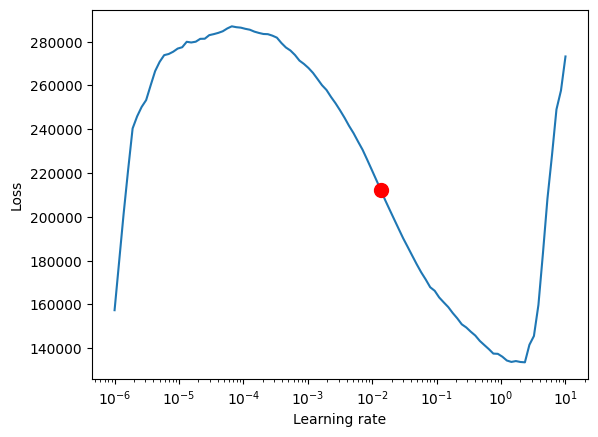

C:\Users\Asus\AppData\Local\Temp\ipykernel_18364\2949586714.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [17]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### -------- code working above this point ---------------------------

In [29]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# Early stopping callback
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=True, mode="min")

# Trainer configuration
trainer = Trainer(
    max_epochs=30,  # Adjust epochs based on dataset size
    accelerator="cpu",  # Specify CPU usage
    devices=1,  # Number of CPU cores to use
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
from pytorch_lightning import LightningModule

class TFTLightningModule(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, batch):
        # The batch should already contain the necessary keys
        return self.tft_model(batch)

    def training_step(self, batch, batch_idx):
        y_hat = self(batch)
        loss = self.tft_model.loss(y_hat, batch["target"])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(batch)
        loss = self.tft_model.loss(y_hat, batch["target"])
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.tft_model.parameters(), lr=1e-3)
        return optimizer


In [35]:
trainer.fit(
    tft_lightning,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



  | Name      | Type                      | Params | Mode
---------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 65.1 K | eval
---------------------------------------------------------------
65.1 K    Trainable params
0         Non-trainable params
65.1 K    Total params
0.260     Total estimated model params size (MB)
0         Modules in train mode
1755      Modules in eval mode


TypeError: tuple indices must be integers or slices, not str

In [ ]:

# Save the model
tft.save_model("tft_model.pth")
print("Model training complete and saved.")


# Train Model

In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1000, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=70,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

---
---
---
---
---

In [40]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl
from torch.utils.data import DataLoader
from torch_optimizer import Ranger

from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


# Set seed for reproducibility
pl.seed_everything(42)

# Load dataset
data = pd.read_csv("finaldata.csv")
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Add time index
data['time_idx'] = np.arange(len(data))

# Drop unused columns
data = data.drop(['DayOfWeek', 'month'], axis=1)

# Validate data
if data.isna().sum().sum() > 0:
    raise ValueError("Dataset contains NaN values. Please clean the data.")

# Normalize non-Date columns
data.loc[:, data.columns != 'Date'] = data.loc[:, data.columns != 'Date'].apply(
    lambda x: (x * 100).astype(int) if x.dtype != 'int' else x
)

# Add a dummy group ID for TimeSeriesDataSet
data["dummy_group"] = 0

# Define TimeSeriesDataSet parameters
max_encoder_length = 240*5  # Change based on dataset requirements
max_prediction_length = 20  # Change based on dataset requirements

dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="niftyPrice",
    group_ids=["dummy_group"], 
    time_varying_known_reals=[
        "vixPrice", "vixChange%", "niftyChange %", "n5day", "n10day", "n20day", "n1day", "n60day",
        "nc5day", "nc10day", "nc20day", "nc1day", "nc60day", "v5day", "v10day", "v20day", "v1day",
        "v60day", "vc5day", "vc10day", "vc20day", "vc1day", "vc60day",
        "Tuesday", "Wednesday", "Friday", "Monday", "Thursday", "Saturday", "Sunday", "March",
        "April", "May", "June", "July", "August", "September", "October", "November", "December",
        "January", "February", "n1day%", "n5day%", "n10day%", "n20day%", "n60day%", "cluster",
        "Month", "GoldPrice", "GoldChange %", "CrudePrice", "CrudeChange %", "inrPrice", "inrChange %",
        "diPrice", "diChange %", "T10Y2Y", "T10Y2Y%chng", "SnP500Price", "SnP500Change %",
        "Fedinterest", "Fed%change", "FedinterestAnticepation", "Rbiinterest", "Rbi%change",
        "RbiinterestAnticepation", "USInflation Rate (%)", "USInflationRate%chng",
        "USInflation Rate (%)Anticepation", "IndiaInflationRate(%)", "IndiaInflationRate(%)chng",
        "IndiaInflationRate(%)Anticepation", "IndiaBudgetDatesAnticipation",
        "IndiaElectionDatesAnticipation", "UsElectionDatesAnticipation"
    ],
    time_varying_unknown_reals=["niftyPrice"], 
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=False
)

# Validation dataset
validation = TimeSeriesDataSet.from_dataset(dataset, data, predict=True, stop_randomization=True)

# Create dataloaders
def collate_fn(batch):
    return {
        "encoder_lengths": torch.tensor([b["encoder_lengths"] for b in batch]),
        "decoder_lengths": torch.tensor([b["decoder_lengths"] for b in batch]),
        "encoder_cat": torch.stack([b["encoder_cat"] for b in batch]),
        "decoder_cat": torch.stack([b["decoder_cat"] for b in batch]),
        "encoder_cont": torch.stack([b["encoder_cont"] for b in batch]),
        "decoder_cont": torch.stack([b["decoder_cont"] for b in batch]),
        "target": torch.stack([b["target"] for b in batch]),
    }




batch_size = 32
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn)
# train_dataloader = dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


Seed set to 42


In [42]:

# Define the TemporalFusionTransformer
tft = TemporalFusionTransformer.from_dataset(
    dataset,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in TFT: {tft.size()/1e3:.1f}k")


Number of parameters in TFT: 120.1k                                


In [43]:

# Define LightningModule wrapper
from pytorch_lightning import LightningModule

class TFTLightningModule(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, batch):
        return self.tft_model(batch)

    def training_step(self, batch, batch_idx):
        y_hat = self(batch)
        loss = self.tft_model.loss(y_hat, batch["target"])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(batch)
        loss = self.tft_model.loss(y_hat, batch["target"])
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = Ranger(self.tft_model.parameters(), lr=1e-3)
        return optimizer



In [44]:

# Initialize model wrapper
tft_lightning = TFTLightningModule(tft)

# Configure trainer
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)
trainer = Trainer(
    max_epochs=30,
    accelerator="cpu",
    devices=1,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [45]:

# Train the model
trainer.fit(
    tft_lightning,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 120 K  | train
----------------------------------------------------------------
120 K     Trainable params
0         Non-trainable params
120 K     Total params
0.480     Total estimated model params size (MB)
2367      Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

TypeError: tuple indices must be integers or slices, not str